# Call Reports Analysis

##### Housekeeping and loading data

In [68]:
# Load packages
import os
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'
path_output = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/output'

# Set path to be the directory:
os.chdir(path)

In [70]:
fed_funds = pd.read_csv('FEDFUNDS.csv', parse_dates = ['DATE'])

# Rename 'DATE' to 'Date' in fed_funds:
fed_funds = fed_funds.rename(columns = {'DATE':'Date'})

# Divide FEDFUNDS by 100 to get the interest rate in percentage terms:
fed_funds['FEDFUNDS'] = fed_funds['FEDFUNDS']/100

In [71]:
# Make the dates in fed_funds to be the last day of the previous month:
fed_funds['Date'] = fed_funds['Date'] - pd.DateOffset(days = 1)

In [72]:
# Read file that contains only the variables of interest, specify that the column 'Date' is a date:
main = pd.read_csv('call_reports.csv', parse_dates = ['Date'])

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\914245168.py:2: DtypeWarning: Columns (31,72,234,285,311) have mixed types. Specify dtype option on import or set low_memory=False.
  main = pd.read_csv('call_reports.csv', parse_dates = ['Date'])


In [73]:
# drop all columns in main that start with 'Unnamed':
main = main.loc[:, ~main.columns.str.contains('^Unnamed')]

main['Year'] = main['Date'].dt.year

In [74]:
# merge the data:
main  = pd.merge(main, fed_funds, how = 'left', on = 'Date').sort_values(by = ['IDRSSD', 'Date'])

##### Basic Definitions

In [75]:
main['Total Deposit'] = np.where(main['Date'] < '2017-01-01', main['RCON3485']+main['RCONB563']+main['RCONA514']+main['RCONA529'], 
                                     main['RCON3485']+main['RCONB563']+main['RCONHK16']+main['RCONHK17'])

main.rename(columns = {'RCFD2170':'Total Assets'}, inplace = True)

In [76]:
#main = main[(main['Total Assets'] > 0) & (main['Total Deposit'] > 0)]
main = main[main['Total Deposit']>0]

In [77]:
# Create a new column that will contain the deposit expenditure it will sum 'RIADA517', 'RIADA518', 'RIAD4508', 'RIAD0093' for
# any date before 2017:
main['Deposit Expenditure'] = np.where(main['Date'] < '2017-01-01', main['RIADA517']+main['RIADA518']+main['RIAD4508']+main['RIAD0093'], 
                            main['RIADHK03']+main['RIADHK04']+main['RIAD4508']+main['RIAD0093'])

# Group by 'ID' and compute the difference in 'Deposit_Expenditure' to get the actual expenditure per period
main['Actual Expenditure'] = main.groupby(['IDRSSD', 'Year'])['Deposit Expenditure'].diff().fillna(main['Deposit Expenditure'])

# get the variation in deposits per period:
main['Deposit Variation'] = main.groupby(['IDRSSD'])['Total Deposit'].diff()

# Compute the Aggregate Deposits as the sum of all deposits in a given date:
main['Aggregate Deposits'] = main.groupby('Date')['Total Deposit'].transform('sum')

# get the variation of 'Aggregate Deposits':
main['Aggregate Deposits Variation'] = main.groupby('IDRSSD')['Aggregate Deposits'].diff()
main['Pct. Aggregate Deposits Variation'] = main.groupby('IDRSSD')['Aggregate Deposits'].pct_change()

# compute the share of deposits of a given bank in the total deposits of all banks in a given date:
main['Deposit Share'] = main['Total Deposit']/main.groupby('Date')['Total Deposit'].transform('sum')

# Calculate s_{it} - s_{it-1} (Deposit Share Variation)
main['Deposit Share Variation'] = main.groupby('IDRSSD')['Deposit Share'].diff()

In [78]:
# Rename RCONB563 as 'Savings Accounts':
main.rename(columns = {'RCONB563':'Savings Accounts', 'RCON3485': 'Transaction Accounts'}, inplace = True)

# Small TDs
main['Small TD'] = np.where(main['Date'] < '2017-01-01', main['RCONA529'], main['RCONHK16']) 
main['Small TD Exp'] = np.where(main['Date'] < '2017-01-01', main['RIADA518'], main['RIADHK03'])
main['Actual Small TD Exp'] = main.groupby(['IDRSSD', 'Year'])['Small TD Exp'].diff().fillna(main['Small TD Exp'])
main['Small TD Rate'] =   main['Actual Small TD Exp'] / main['Small TD']
main['Small TD Share'] = main['Small TD'] / main['Total Deposit']

# Large TDs
main['Large TD'] = np.where(main['Date'] < '2017-01-01', main['RCONA514'], main['RCONHK17']) 
main['Large TD Exp'] = np.where(main['Date'] < '2017-01-01', main['RIADA517'], main['RIADHK04'])
main['Actual Large TD Exp'] = main.groupby(['IDRSSD', 'Year'])['Large TD Exp'].diff().fillna(main['Large TD Exp'])
main['Large TD Rate'] = main['Actual Large TD Exp'] / main['Large TD']
main['Large TD Share'] = main['Large TD'] / main['Total Deposit']


# Savings
main['Savings Rate'] = main.groupby(['IDRSSD', 'Year'])['RIAD0093'].diff().fillna(main['RIAD0093']) / main['Savings Accounts']
main['Savings Share'] = main['Savings Accounts'] / main['Total Deposit']

# Transaction
main['Transaction Share'] = main['Transaction Accounts'] / main['Total Deposit']

In [79]:
main['Cash'] = main['RCFD0081']+main['RCFD0071'] 

# define securities variable (include HTM and AFS)
main['HTM Securities'] = np.where(main['Date'].dt.year < 2019, main['RCFD1754'], main['RCFDJJ34'])
main.rename(columns={'RCFD1773':'AFS Securities'}, inplace=True)
main['Securities'] = main['HTM Securities'] + main['AFS Securities'] #+ main['RCFDJA22']
main['FF sold and repo assets'] = main['RCONB987']+main['RCFDB989']

In [80]:
balanced_panel = 0

if balanced_panel == 1:

    # Step 1: Count the total number of unique dates in the dataset
    total_dates = main['Date'].nunique()
    print('Number of dates:', total_dates)

    # Step 2: Count the number of unique dates each bank shows up
    bank_date_counts = main[main['Total Deposit'] > 0].groupby('IDRSSD')['Date'].nunique()
    print('Banks that show up in all dates:', sum(bank_date_counts==total_dates))

    # Step 3: Identify banks that are present in all dates with positive 'Total Deposit':
    banks = bank_date_counts[bank_date_counts == total_dates].index
    main = main[main['IDRSSD'].isin(banks)]


In [81]:
# Compute deposit rates:
main['Deposit Rate'] = main['Actual Expenditure'] / main['Total Deposit']
main['Deposit Spread'] = -main['Deposit Rate'] + main['FEDFUNDS']

# Average the deposit rate by 'Date', weighting by 'Total Deposit':
main['Weighted Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform(lambda x: np.average(x, weights = main.loc[x.index, 'Total Deposit']))

In [82]:
# Create an extra column in df3 with the avg. deposit rate per Date:
main['Avg. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('mean')
main['Std. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('std')
main['R_hat'] = (main['Deposit Rate'] - main['Avg. Deposit Rate']) / main['Std. Deposit Rate']

In [83]:
# Data on repos
# Expenditure
main['Income Repo']         = main['RIAD4020']
main['Expenditure Repo']    = main['RIAD4180']

# Quantities
main['Repo Loans']          = main['RCFD3365']
main['Repo Debt']           = main['RCFD3353']

# Group by 'ID' and compute the difference in 'Deposit_Expenditure' to get the actual expenditure per period
main['Actual Expenditure Repo'] = main.groupby(['IDRSSD', 'Year'])['Expenditure Repo'].diff().fillna(main['Expenditure Repo'])
main['Actual Income Repo'] = main.groupby(['IDRSSD', 'Year'])['Expenditure Repo'].diff().fillna(main['Income Repo'])

In [84]:
# Maturity of deposits
main['Small TD Maturity'] = np.where(main['Date'] < '2017-01-01', 0.25*main['RCONA579']+15/12*main['RCONA580']+2*main['RCONA581']+3*main['RCONA582'],
                               0.25*main['RCONHK07']+15/12*main['RCONHK08']+2*main['RCONHK09']+5*main['RCONHK10'])
main['Large TD Maturity'] = np.where(main['Date'] < '2017-01-01', 0.25*main['RCONA584']+15/12*main['RCONA585']+2*main['RCONA586']+3*main['RCONA587'],
                               0.25*main['RCONHK12']+15/12*main['RCONHK13']+2*main['RCONHK14']+5*main['RCONHK15'])
main['Deposit Maturity'] = (0*(main['Transaction Accounts'] + main['Savings Accounts'])+ 5*main['RCON3200'] + main['Small TD Maturity'] + main['Large TD Maturity'])/(main['Transaction Accounts'] + main['Savings Accounts'] + main['Small TD'] + main['Large TD'])

# MISSING THE "(...) and Fed funds purchased"                         

## Deposits

##### Intro plot

In [85]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',             # IDRSSD and Date 
            'Total Deposit', 'Deposit Share',                           # Bank specific qunatity variables
            'Deposit Rate', 'R_hat',                                    # Bank specific rate variable
            'Aggregate Deposits',       # Aggregate quantity variables 
            'FEDFUNDS', 'Weighted Deposit Rate'                         # Aggregate rate variables
            ]]

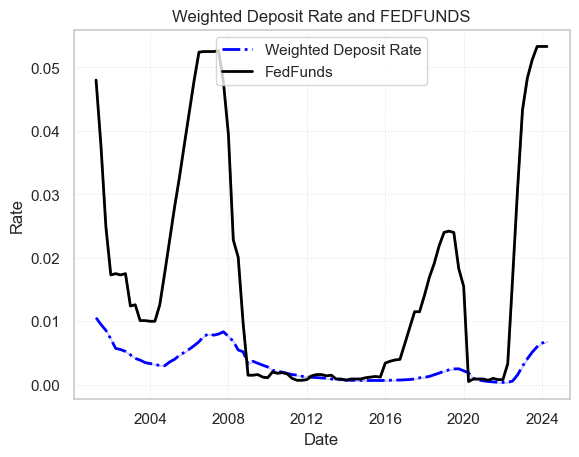

In [86]:
# plot the time series of 'Weighted Deposit Rate' and 'FEDFUNDS':
sns.lineplot(data = df, x = 'Date', y = 'Weighted Deposit Rate', 
             label = 'Weighted Deposit Rate', color = 'blue', linewidth = 2, linestyle = '-.')
sns.lineplot(data = df, x = 'Date', y = 'FEDFUNDS', 
             label = 'FedFunds', color = 'black', linestyle = '-', linewidth = 2)
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Weighted Deposit Rate and FEDFUNDS')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend(loc='upper center')
plt.show()

In [87]:
# Until here, dataset matches with Lucas.
#df2[(df2['Date']>'2023-01-01') & (df2['Date']<'2024-01-01')]['Deposit Rate'].describe()

##### Distribution of deposit rates

In [88]:
df_bottom = df.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
                                                 (x['Total Deposit'] <= x['Total Deposit'].quantile(0.95))]).reset_index(drop=True)
df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total Deposit'].quantile(0.95)]).reset_index(drop=True)


C:\Users\angel\AppData\Local\Temp\ipykernel_42788\3785463281.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bottom = df.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
C:\Users\angel\AppData\Local\Temp\ipykernel_42788\3785463281.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total

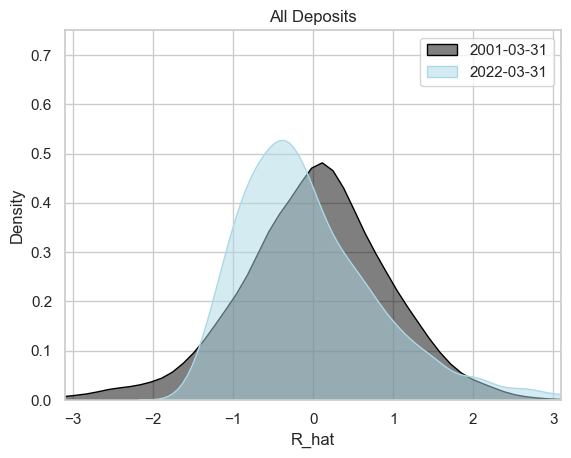

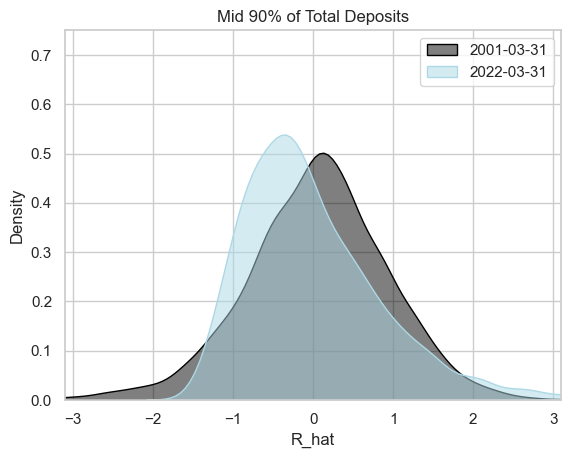

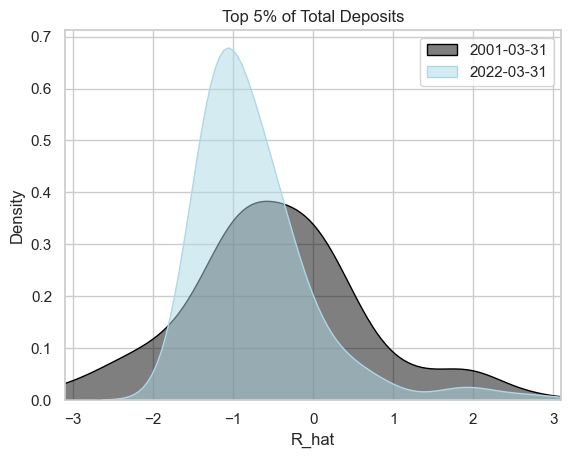

In [89]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df[df['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df[df['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.title('All Deposits')
plt.show()

# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_bottom[df_bottom['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_bottom[df_bottom['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
#Adjust the x-axis to be able to see the distribution better:
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.title('Mid 90% of Total Deposits')
plt.show()



# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_top[df_top['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_top[df_top['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.legend()
plt.title('Top 5% of Total Deposits')
plt.show()

##### What type of funding banks use?

In [90]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',                           # Dates and IDS 
            'Total Deposit', 'Small TD', 'Large TD', 
            'Savings Accounts', 'Transaction Accounts',                               # Deposit type variables
            'Deposit Share', 'Deposit Variation',                                     # Bank specific quantity variables
            'Small TD Share', 'Large TD Share', 'Savings Share', 'Transaction Share', # Deposit type shares
            'Deposit Rate', 'R_hat',                                                  # Bank specific rate variable
            'Savings Rate', 'Large TD Rate', 'Small TD Rate',                         # Deposit type rates
            'Aggregate Deposits', 'Aggregate Deposits Variation',                     # Aggregate quantity variables 
            'FEDFUNDS', 'Weighted Deposit Rate'                                       # Aggregate rate variables
            ]]

In [91]:
# take the top 10 banks in 'Total Deposit' in the most recent date, and plot their deposit rates:
top_10_today = df[df['Date'] == df['Date'].max()].nlargest(10, 'Total Deposit')['Financial Institution Name']

In [92]:
# make a dataset that has only the top 10 banks in 'Total Deposit' per year:
df_top10 = df.groupby(['Date']).apply(lambda x: x.nlargest(10, 'Total Deposit')).reset_index(drop=True)

# compute the share of each bank in the total deposits of the top 10 banks per year:
df_top10['Share in Top 10'] = df_top10['Total Deposit'] / df_top10.groupby('Date')['Total Deposit'].transform('sum')

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\527871687.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top10 = df.groupby(['Date']).apply(lambda x: x.nlargest(10, 'Total Deposit')).reset_index(drop=True)


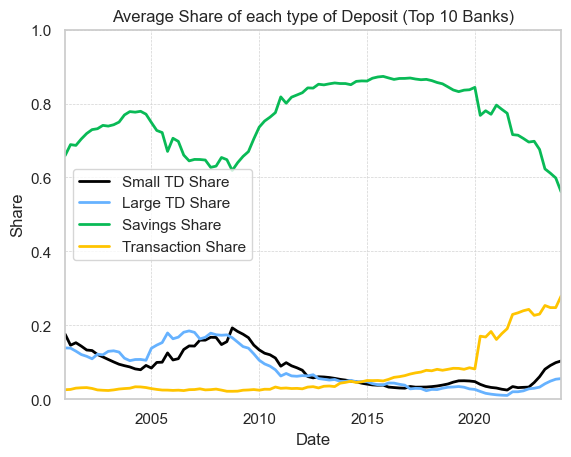

In [93]:
# Group by 'Date' and sum the weighted shares:
df_top10_unweighted_shares = df_top10.groupby('Date')[['Small TD Share', 'Large TD Share', 
                                    'Savings Share', 'Transaction Share']].mean().reset_index()

# plot the weighted average share of each type of deposit for the top 10 banks:
df_top10_unweighted_shares.set_index('Date').plot(markersize=2, linewidth=2, 
                                color=['black', '#66B2FF', '#09BA56', '#FFC400'])
plt.xlabel('Date')
plt.ylabel('Share')
plt.ylim(0, 1)
plt.title('Average Share of each type of Deposit (Top 10 Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()


In [94]:
df_top10_unweighted = df_top10.groupby('Date')[['Small TD', 'Large TD', 
                                    'Savings Accounts', 'Transaction Accounts']].mean().reset_index()

# make the stacked barplot as in the cell below, but divide deposits by 1e6:
df_top10_unweighted[['Small TD', 'Large TD', 'Savings Accounts', 'Transaction Accounts']] = df_top10_unweighted[['Small TD', 'Large TD', 'Savings Accounts', 'Transaction Accounts']]/1e6

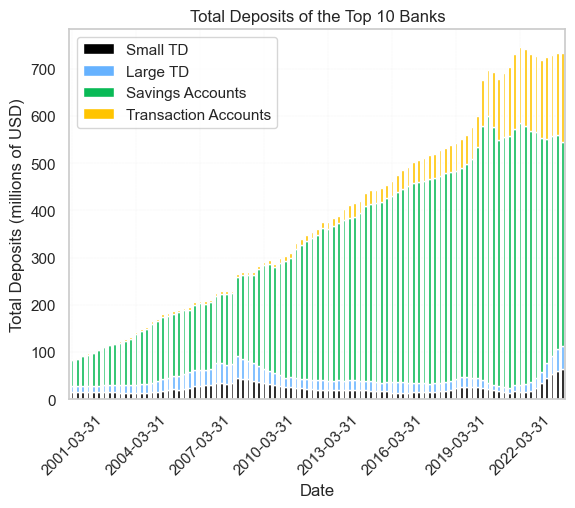

In [95]:
# make a stacked bar plot of the total deposits of the top 10 banks:
df_top10_unweighted.set_index('Date').plot(kind='bar', stacked=True, color=['black', '#66B2FF', '#09BA56', '#FFC400'])
# divide the values in the y-axis by 1e6 to make the numbers more readable:
# add just some ticks in the x-axis in the format 'YYYY-MM-DD':
plt.xticks(np.arange(0, len(df_top10_unweighted), 12), df_top10_unweighted['Date'].dt.strftime('%Y-%m-%d')[::12], rotation=45)
plt.xlabel('Date')
plt.ylabel('Total Deposits (millions of USD)')
plt.title('Total Deposits of the Top 10 Banks')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.1)
plt.show()

In [96]:
# compute the weighted average of the share of each type of deposit for the top 10 banks, weighted by 'Share in Top 10':
df_top10['Weighted Small TD Share'] = df_top10['Small TD Share'] * df_top10['Share in Top 10']
df_top10['Weighted Large TD Share'] = df_top10['Large TD Share'] * df_top10['Share in Top 10']
df_top10['Weighted Savings Share'] = df_top10['Savings Share'] * df_top10['Share in Top 10']
df_top10['Weighted Transaction Share'] = df_top10['Transaction Share'] * df_top10['Share in Top 10']

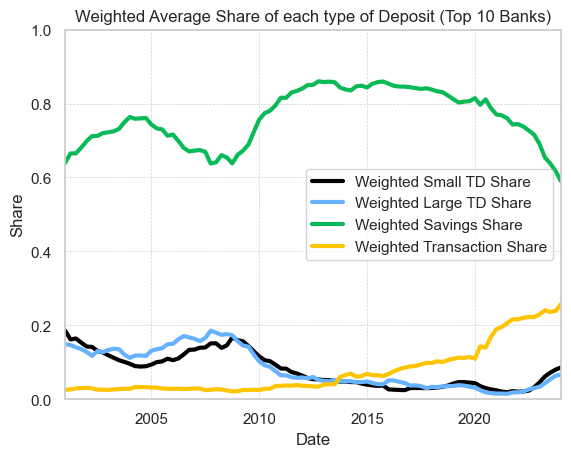

In [97]:
# Group by 'Date' and sum the weighted shares:
df_top10_weighted = df_top10.groupby('Date')[['Weighted Small TD Share', 'Weighted Large TD Share', 
                                    'Weighted Savings Share', 'Weighted Transaction Share']].sum().reset_index()

# plot the weighted average share of each type of deposit for the top 10 banks:
df_top10_weighted.set_index('Date').plot(markersize=2, linewidth=3, 
                                color=['black', '#66B2FF', '#09BA56', '#FFC400'])
plt.xlabel('Date')
plt.ylabel('Share')
plt.ylim(0, 1)
plt.title('Weighted Average Share of each type of Deposit (Top 10 Banks)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()

##### Where does this dispersion is coming from?

In [98]:
# Create an extra column in df3 with the avg. deposit rate per Date:
df2 = df[(df['Savings Accounts']>0) & (df['Small TD']>0) & (df['Large TD']>0)].copy()

df2['Avg. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('mean')
df2['Std. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('std')
df2['Savings_hat'] = (df2['Savings Rate'] - df2['Avg. Savings Rate']) / df2['Std. Savings Rate']

In [99]:
df3 = df[(df['Savings Accounts']>0) & (df['Small TD']>0) & (df['Large TD']>0)].copy()
df3 = df3.groupby('Date').apply(lambda x: x[(x['Small TD'] >= x['Small TD'].quantile(0.01)) & (x['Small TD'] <= x['Small TD'].quantile(0.99))]).reset_index(drop=True)

df3['Avg. Small TD Rate'] = df3.groupby('Date')['Small TD Rate'].transform('mean')
df3['Std. Small TD Rate'] = df3.groupby('Date')['Small TD Rate'].transform('std')
df3['Small_TD_hat'] = (df3['Small TD Rate'] - df3['Avg. Small TD Rate']) / df3['Std. Small TD Rate']

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\1251671019.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df3 = df3.groupby('Date').apply(lambda x: x[(x['Small TD'] >= x['Small TD'].quantile(0.01)) & (x['Small TD'] <= x['Small TD'].quantile(0.99))]).reset_index(drop=True)


In [100]:
df2_bottom = df2.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05)) &
                                                 (x['Total Deposit'] <= 
                                                  x['Total Deposit'].quantile(0.95))]).reset_index(drop=True)
df2_top = df2.groupby('Date').apply(lambda x: x[x['Total Deposit'] >=
                                            x['Total Deposit'].quantile(0.95)]).reset_index(drop=True)

df3_bottom = df3.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05))&
                                    (x['Total Deposit'] <= x['Total Deposit'].quantile(0.95))]).reset_index(drop=True)
df3_top = df3.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= 
                                                x['Total Deposit'].quantile(0.95)]).reset_index(drop=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\710382694.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2_bottom = df2.groupby('Date').apply(lambda x: x[(x['Total Deposit'] >= x['Total Deposit'].quantile(0.05)) &
C:\Users\angel\AppData\Local\Temp\ipykernel_42788\710382694.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2_top = df2.groupby('Date').apply(lambda x: x[x['Total Deposit'] >=
C:\Us

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\672968106.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(df2_top[df_top['Date']=='2001-03-31']['Savings_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
C:\Users\angel\AppData\Local\Temp\ipykernel_42788\672968106.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(df2_top[df_top['Date']=='2022-03-31']['Savings_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)


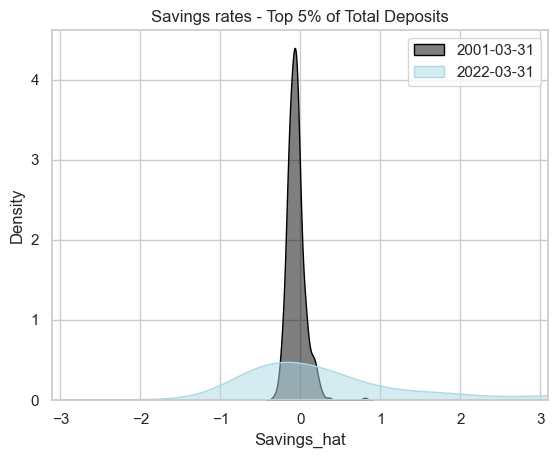

In [101]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df2_top[df_top['Date']=='2001-03-31']['Savings_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df2_top[df_top['Date']=='2022-03-31']['Savings_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.legend()
plt.title('Savings rates - Top 5% of Total Deposits')
plt.savefig(path_output + '/savings_top5.svg')
plt.show()

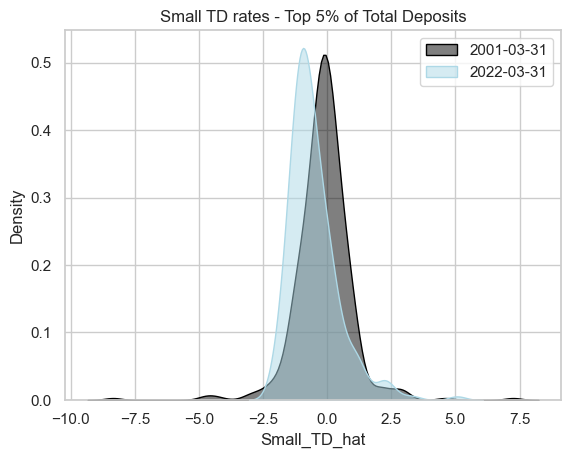

In [102]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df3_top[df3_top['Date']=='2001-03-31']['Small_TD_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df3_top[df3_top['Date']=='2022-03-31']['Small_TD_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
#plt.xlim(-0.02, 0.02)
plt.legend()
plt.title('Small TD rates - Top 5% of Total Deposits')
plt.savefig(path_output + '/smallTD_top5.svg')
plt.show()

##### Tracking deposits

In [103]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',                           # Dates and IDS 
            'Total Deposit', 'Deposit Share', 
            'Deposit Variation', 'Deposit Share Variation',                           # Bank specific quantity variables
            'Deposit Rate', 'R_hat', 'Deposit Spread',                                                  # Bank specific rate variable
            'Savings Rate',                                                           # Deposit type rates
            'Aggregate Deposits', 'Aggregate Deposits Variation',                     # Aggregate quantity variables 
            'FEDFUNDS', 'Weighted Deposit Rate'                                       # Aggregate rate variables
            ]]

In [104]:
# Drop the NaN values in the 'variation' variables:
#df = df.dropna(subset = ['Deposit Variation', 'Aggregate Deposits Variation'])

# compute the 'Growth Rate' variable by subtracting log of 'Total Deposit' in t-1 from log of 'Total Deposit' in t:
df['Growth Rate'] = np.log(df['Total Deposit']).diff()

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\1161658321.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Growth Rate'] = np.log(df['Total Deposit']).diff()


In [105]:
# do the same plot as above for the top 50 banks in 'Total Deposit' in March 2019:
how_many = 50
top_how_many = df[df['Date'] == '2019-03-31'].nlargest(how_many, 'Total Deposit')['IDRSSD']

In [106]:
# Create a 'Time' column that attributes a number to each date:
df['Time'] = df.groupby('Date').ngroup()

# Regress log(Aggretate Deposits) on 'Time'. Save the de-trended series in 'Detrended Agg. Deposits':
df['Detrended Agg. Deposits'] = sm.OLS(np.log(df['Aggregate Deposits']), sm.add_constant(df['Time'])).fit().resid

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\4091312879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = df.groupby('Date').ngroup()
C:\Users\angel\AppData\Local\Temp\ipykernel_42788\4091312879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Detrended Agg. Deposits'] = sm.OLS(np.log(df['Aggregate Deposits']), sm.add_constant(df['Time'])).fit().resid


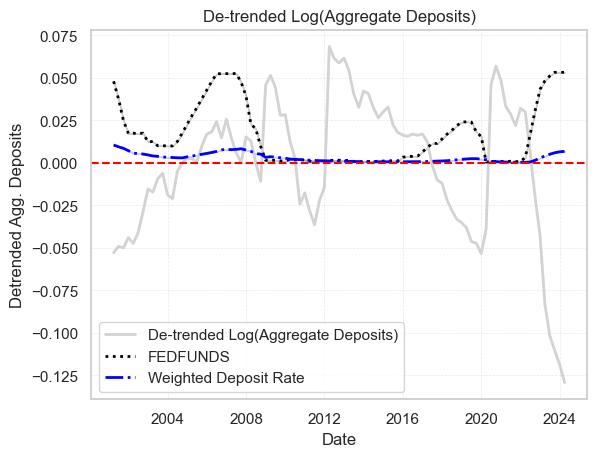

In [107]:
# Plot the de-trended series:
sns.lineplot(data = df, x = 'Date', y = 'Detrended Agg. Deposits', linewidth = 2, 
             color = 'lightgrey', label = 'De-trended Log(Aggregate Deposits)')
# add the FEDFUNDS rate:
sns.lineplot(data = df, x = 'Date', y = 'FEDFUNDS', linewidth = 2, 
             color = 'black', label = 'FEDFUNDS', linestyle=':')
# add the weighted deposit rate:
sns.lineplot(data = df, x = 'Date', y = 'Weighted Deposit Rate', linewidth = 2, 
             color = 'blue', linestyle='-.', label = 'Weighted Deposit Rate')
# add a horizontal line at 0:
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date')
plt.title('De-trended Log(Aggregate Deposits)')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.legend(loc='lower left')
plt.show()

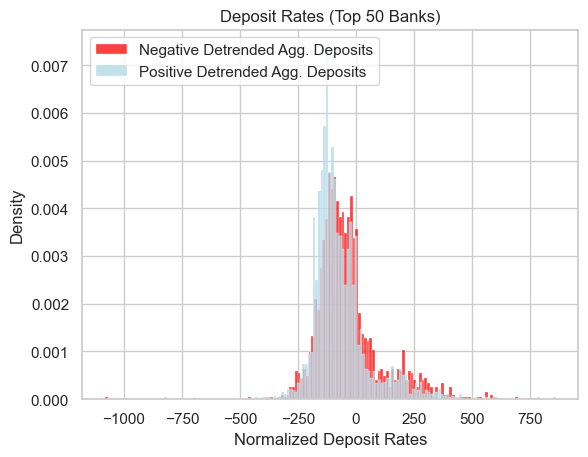

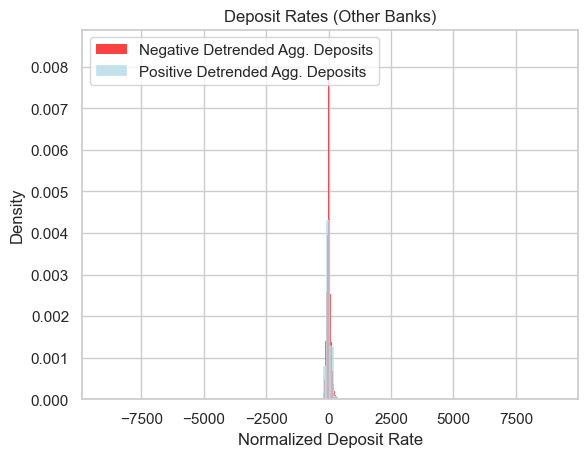

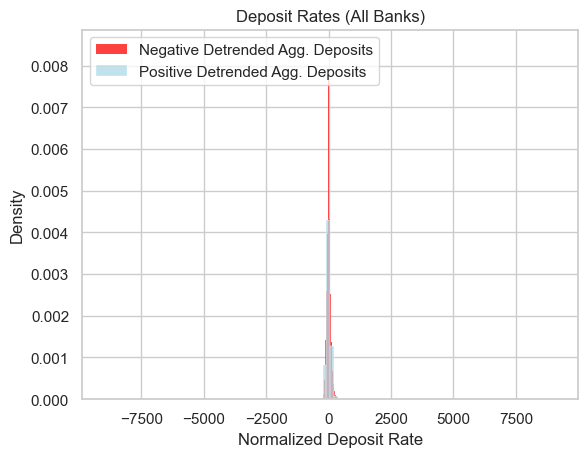

In [108]:
# for all the moments where the 'Detrended Agg. Deposits' is below 0, plot make a histogram of the 'Deposit Variation':
sns.histplot(df[(df['Detrended Agg. Deposits'] < 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 150, color = 'red', stat = 'density')
sns.histplot(df[(df['Detrended Agg. Deposits'] > 0) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat']*100, bins = 150, color = 'lightblue', stat = 'density')
plt.xlabel('Normalized Deposit Rates')
plt.ylabel('Density')
plt.title(f'Deposit Rates (Top {how_many} Banks)')
#plt.xlim(-1, 1)
plt.legend(['Negative Detrended Agg. Deposits', 'Positive Detrended Agg. Deposits'], loc='upper left')
plt.show()

# for all the moments where the 'Detrended Agg. Deposits' is below 0, plot make a histogram of the 'Deposit Variation':
sns.histplot(df[(df['Detrended Agg. Deposits'] < 0) &
                (~df['IDRSSD'].isin(top_how_many))]['R_hat']*100, bins = 2000, color = 'red', stat = 'density')
sns.histplot(df[(df['Detrended Agg. Deposits'] > 0) &
                (~df['IDRSSD'].isin(top_how_many))]['R_hat']*100, bins = 100, color = 'lightblue', stat = 'density')
plt.xlabel('Normalized Deposit Rate')
plt.ylabel('Density')
plt.title(f'Deposit Rates (Other Banks)')
#plt.xlim(-1, 1)
plt.legend(['Negative Detrended Agg. Deposits', 'Positive Detrended Agg. Deposits'], loc='upper left')
plt.show()

# for all the moments where the 'Detrended Agg. Deposits' is below 0, plot make a histogram of the 'Deposit Variation':
sns.histplot(df[(df['Detrended Agg. Deposits'] < 0)]['R_hat']*100, bins = 2000, color = 'red', stat = 'density')
sns.histplot(df[(df['Detrended Agg. Deposits'] > 0)]['R_hat']*100, bins = 100, color = 'lightblue', stat = 'density')
plt.xlabel('Normalized Deposit Rate')
plt.ylabel('Density')
plt.title(f'Deposit Rates (All Banks)')
#plt.xlim(-1, 1)
plt.legend(['Negative Detrended Agg. Deposits', 'Positive Detrended Agg. Deposits'], loc='upper left')
plt.show()

In [109]:
# create a variable named 'FF Hike' that is 1 if the FEDFUNDS rate increased, 0 otherwise:
df['FF Hike'] = df['FEDFUNDS'].diff().apply(lambda x: 1 if x >= 0 else 0)

# create a variable named 'FF Cut' that is 1 if the FEDFUNDS rate decreased, 0 otherwise:
df['FF Cut'] = df['FEDFUNDS'].diff().apply(lambda x: 1 if x < 0 else 0)

# compute the mean of 'FEDFUNDS' accross all dates:
mean_fedfunds = df['FEDFUNDS'].mean()

# create a variable named 'FF High' that is 1 if the FEDFUNDS rate is above the mean, 0 otherwise:
df['FF High'] = df['FEDFUNDS'].apply(lambda x: 1 if x > mean_fedfunds else 0)

C:\Users\angel\AppData\Local\Temp\ipykernel_42788\3547520127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FF Hike'] = df['FEDFUNDS'].diff().apply(lambda x: 1 if x >= 0 else 0)
C:\Users\angel\AppData\Local\Temp\ipykernel_42788\3547520127.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FF Cut'] = df['FEDFUNDS'].diff().apply(lambda x: 1 if x < 0 else 0)
C:\Users\angel\AppData\Local\Temp\ipykernel_42788\3547520127.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

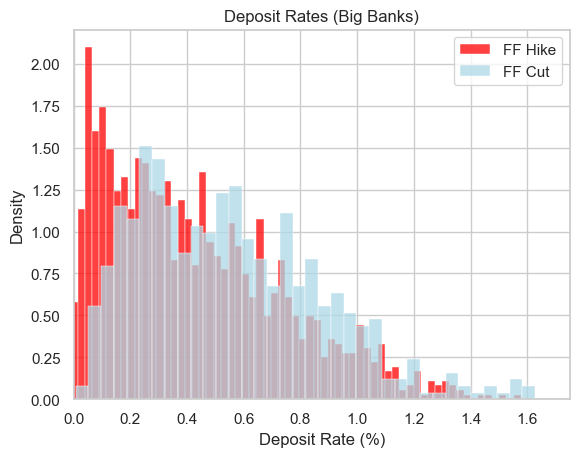

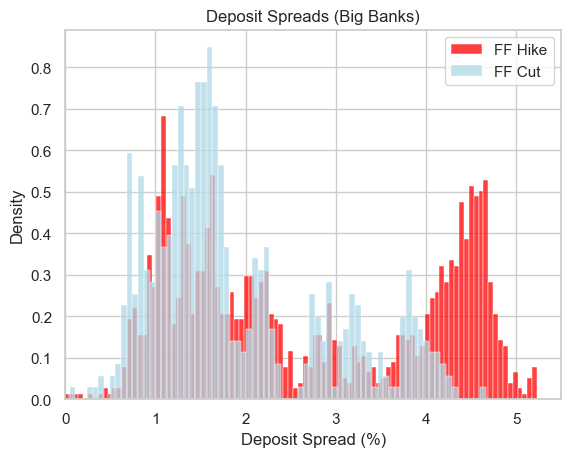

In [110]:
# plot the histogram of 'R_hat' for moments where the 'Detrended Agg. Deposits' is below/above 0, and when 'FF Hike' is 1:
sns.histplot(df[(df['FF Hike'] == 1) & (df['FEDFUNDS']>0.01) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['Deposit Rate']*100, bins = 100, color = 'red', stat = 'density', kde=False)
sns.histplot(df[(df['FF Cut'] == 1) & (df['FEDFUNDS']>0.01) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['Deposit Rate']*100, bins = 100, color = 'lightblue', stat = 'density', kde=False)
plt.xlabel('Deposit Rate (%)')
plt.ylabel('Density')
plt.title(f'Deposit Rates (Big Banks)')
plt.xlim(0, 1.75)
plt.legend(['FF Hike', 'FF Cut'], loc='upper right')
plt.savefig(path_output+'/histogram_deposit_rates_bigbanks.svg', format='svg')
plt.show()

# plot the histogram of 'R_hat' for moments where the 'Detrended Agg. Deposits' is below/above 0, and when 'FF Hike' is 1:
sns.histplot(df[(df['FF Hike'] == 1) & (df['FEDFUNDS']>0.01) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['Deposit Spread']*100, bins = 100, color = 'red', stat = 'density', kde=False)
sns.histplot(df[(df['FF Cut'] == 1) & (df['FEDFUNDS']>0.01) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['Deposit Spread']*100, bins = 100, color = 'lightblue', stat = 'density', kde=False)
plt.xlabel('Deposit Spread (%)')
plt.ylabel('Density')
plt.title(f'Deposit Spreads (Big Banks)')
plt.xlim(0, 5.5)
plt.legend(['FF Hike', 'FF Cut'], loc='upper right')
plt.savefig(path_output+'/histogram_deposit_spreads_bigbanks.svg', format='svg')
plt.show()


In [111]:
# make a test on the variance of 'R_hat' when 'FF Hike' is 1 or 0:
from scipy.stats import levene

stat, pval = levene(df[(df['FF Hike'] == 1) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat'], 
          df[(df['FF Cut'] == 1) &
                (df['IDRSSD'].isin(top_how_many))
                #& (df['Date'].isin(dates_top[dates_top == how_many].index))
                ]['R_hat'])

if pval<0.05:
    print('The p-value of the Levene test is:', pval)
    print('The null of equal variance is rejected.')
    print('The variance of the Deposit Rate is different when the FEDFUNDS rate is hiked.')

stat, pval = levene(df[(df['FF High'] == 1) &
            (df['IDRSSD'].isin(top_how_many))
            #& (df['Date'].isin(dates_top[dates_top == how_many].index))
            ]['R_hat'], 
      df[(df['FF High'] == 0) &
            (df['IDRSSD'].isin(top_how_many))
            #& (df['Date'].isin(dates_top[dates_top == how_many].index))
            ]['R_hat'])

if pval<0.05:
    print('The p-value of the Levene test is:', pval)
    print('The null of equal variance is rejected.')
    print('The variance of the Deposit Rate is different when the FEDFUNDS rate is above avg.')


The p-value of the Levene test is: 3.593418664175435e-08
The null of equal variance is rejected.
The variance of the Deposit Rate is different when the FEDFUNDS rate is hiked.
The p-value of the Levene test is: 7.247090907751419e-11
The null of equal variance is rejected.
The variance of the Deposit Rate is different when the FEDFUNDS rate is above avg.


##### Maturity of Deposits

In [112]:
df = main[['IDRSSD', 'Date', 'Total Deposit', 'Deposit Rate', 'Deposit Maturity', 'FEDFUNDS', 'Weighted Deposit Rate']]

In [113]:
# trim at the 1% and 99% quantiles in 'Deposit Matutiry':
df = df[(df['Deposit Maturity'] >= df['Deposit Maturity'].quantile(0.01)) & (df['Deposit Maturity'] <= df['Deposit Maturity'].quantile(0.99))]

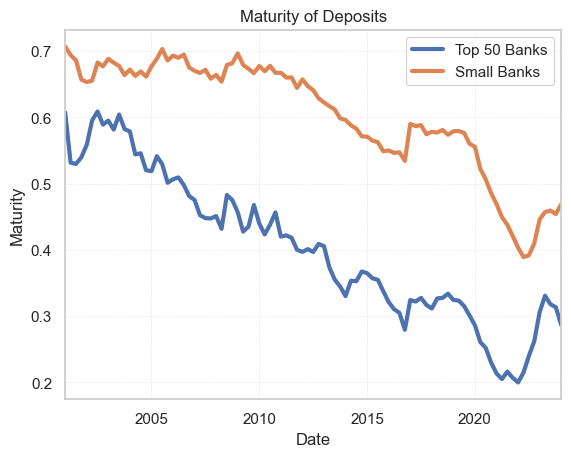

In [114]:
# Make the same plot as above, but for the top 50 banks in 'Total Deposit' in March 2019:
top_50 = df[df['Date'] == '2019-03-31'].nlargest(50, 'Total Deposit')['IDRSSD']

# make the same plot as above considering only IDRSSD in top_50:
df[df['IDRSSD'].isin(top_50)].groupby('Date')['Deposit Maturity'].mean().plot(linewidth=3)
# plot now considering the IDRSSD that are NOT in top_50:
df[~df['IDRSSD'].isin(top_50)].groupby('Date')['Deposit Maturity'].mean().plot(linewidth=3)
plt.xlabel('Date')
plt.ylabel('Maturity')
plt.title('Maturity of Deposits')
plt.legend(['Top 50 Banks', 'Small Banks'])
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()

In [115]:
# describe the 'Deposit Maturity' for before 2017:
df['Deposit Maturity'].describe()

count    601520.000000
mean          0.617610
std           0.268219
min           0.049313
25%           0.426301
50%           0.604702
75%           0.786535
max           1.537127
Name: Deposit Maturity, dtype: float64

## Assets

##### Begeneu et. al (2024)

In [116]:
df = main[['IDRSSD', 'Date', 'Total Assets', 'Cash', 'Securities', 
           'HTM Securities', 'AFS Securities', 'Large TD Share',
           'FF sold and repo assets']]

In [117]:
# keep only observations from 2010 to 2022:
df = df[(df['Date'] >= '2010-01-01') & (df['Date'] <= '2022-12-31')]

# trim by top 5% in 'Total Assets':
df = df[(df['Total Assets'] >= df['Total Assets'].quantile(0.05)) &
        (df['Total Assets'] <= df['Total Assets'].quantile(0.95))]

df['Log Total Assets'] = np.log(df['Total Assets'])
df['Pct. Bin'] = pd.qcut(df['Log Total Assets'], q=100, labels=False) + 1
df['Normalized securities'] = (df['Cash']+df['Securities']+df['FF sold and repo assets']) / df['Total Assets']

# trim by top 5% in 'Total Assets':
df = df[(df['Normalized securities'] >= df['Normalized securities'].quantile(0.05)) &
        (df['Normalized securities'] <= df['Normalized securities'].quantile(0.95))]

In [118]:
df_grouped = df.groupby('Pct. Bin')[['Normalized securities', 'Log Total Assets', 'Large TD Share']].mean().reset_index()

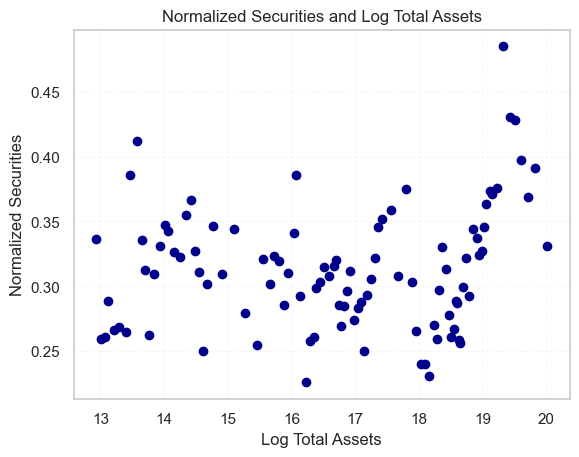

In [119]:
# make a scatter plot of 'Normalized securities' and 'Log Total Assets':
plt.scatter(df_grouped['Log Total Assets'], df_grouped['Normalized securities'], color='darkblue')
plt.xlabel('Log Total Assets')
plt.ylabel('Normalized Securities')
plt.title('Normalized Securities and Log Total Assets')
plt.grid(color = 'lightgray', linestyle = ':', linewidth = 0.5, alpha = 0.5)
plt.show()

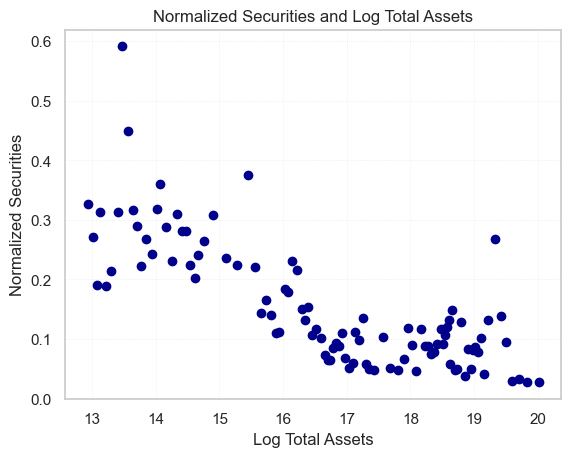

In [120]:
# make a scatter plot of 'Normalized securities' and 'Log Total Assets':
plt.scatter(df_grouped['Log Total Assets'], df_grouped['Large TD Share'], color='darkblue')
plt.xlabel('Log Total Assets')
plt.ylabel('Normalized Securities')
plt.title('Normalized Securities and Log Total Assets')
plt.grid(color = 'lightgray', linestyle = ':', linewidth = 0.5, alpha = 0.5)
plt.show()

##### Granja (2024)

In [121]:
df = main[['IDRSSD', 'Date', 'Total Assets', 'Cash', 'Securities', 
           'HTM Securities', 'AFS Securities', 'Large TD Share', 'Small TD Share',
           'Deposit Rate', 
           'FF sold and repo assets', 'FEDFUNDS']]

In [122]:
df = df[df['Total Assets']>0]

# create 'Log Total Assets':
df['Log Total Assets'] = np.log(df['Total Assets'])

# create a variable named 'FF Hike' that is 1 if the FEDFUNDS rate increased, using .loc function:
df['FF Hike'] = 0
df.loc[df['FEDFUNDS'].diff() > 0, 'FF Hike'] = 1

In [123]:
# compute the Share of HTM/AFS Securities in Securities:
df['HTM Share'] = df['HTM Securities'] / df['Securities']
df['AFS Share'] = df['AFS Securities'] / df['Securities']

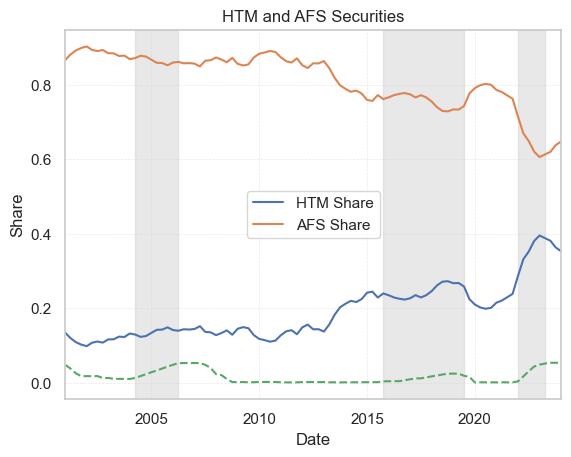

In [124]:
# plot the average share of HTM and AFS securities over time:
df.groupby('Date')[['HTM Share', 'AFS Share', 'FEDFUNDS']].mean().plot()
# I want the FEDFUNDS line to be a dashed black line:
plt.gca().get_lines()[2].set_linestyle('--')
# add a shaded area to the plot in the last interest rate hike cycle:
plt.axvspan('2022-03-01', '2023-06-30', color='lightgray', alpha=0.5)
plt.axvspan('2015-11-30', '2019-07-31', color='lightgray', alpha=0.5)
plt.axvspan('2004-05-01', '2006-05-30', color='lightgray', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Share')
plt.title('HTM and AFS Securities')
plt.legend(['HTM Share', 'AFS Share'])
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()

In [125]:
# compute bins of 'Large TD Share':
df['Bin'] = pd.qcut(df['Log Total Assets'], q=100, labels=False, duplicates='drop') + 1

In [127]:
df_grouped = df.groupby('Bin')[['AFS Share', 'HTM Share', 
                                         'Large TD Share', 'Deposit Rate', 'Small TD Share',
                                         'Log Total Assets']].mean().reset_index()

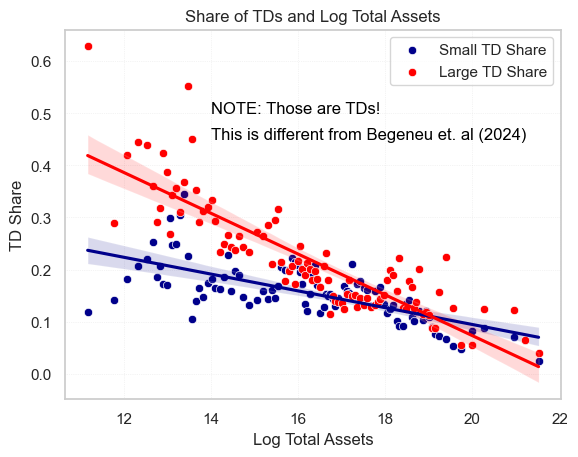

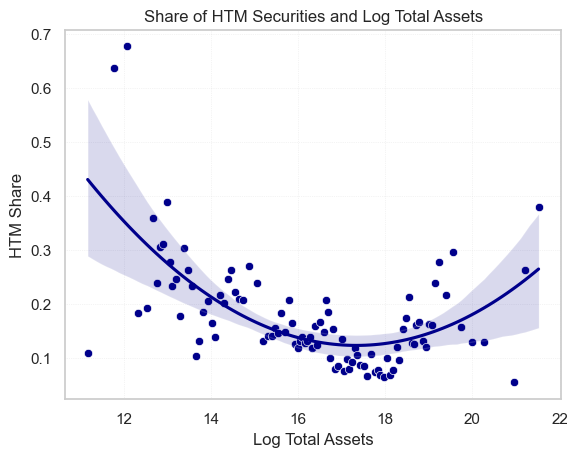

In [128]:
# make a scatter plot of 'Normalized securities' and 'Log Total Assets' using sns:
sns.set(style="whitegrid")
sns.scatterplot(x = 'Log Total Assets', y = 'Small TD Share', data = df_grouped, color='darkblue', label='Small TD Share')
#plt.scatter(df_grouped['Log Total Assets'], df_grouped['Small TD Share'], color='darkblue')
# fit a regression line to the scatter plot:
sns.regplot(x = 'Log Total Assets', y = 'Small TD Share', data = df_grouped, scatter=False, color='darkblue', )
#plt.scatter(df_grouped['Log Total Assets'], df_grouped['Large TD Share'], color='red')
sns.scatterplot(x = 'Log Total Assets', y = 'Large TD Share', data = df_grouped, color='red', label='Large TD Share')
sns.regplot(x = 'Log Total Assets', y = 'Large TD Share', data = df_grouped, scatter=False, color='red', )
plt.xlabel('Log Total Assets')
plt.ylabel('TD Share')
plt.title('Share of TDs and Log Total Assets')
plt.grid(color = 'lightgray', linestyle = ':', linewidth = 0.5, alpha = 0.5)
plt.legend()
plt.text(14, 0.5, "NOTE: Those are TDs!", fontsize=12, color='black')
plt.text(14, 0.45, "This is different from Begeneu et. al (2024)", fontsize=12, color='black')
plt.show()

# make a scatter plot of 'Normalized securities' and 'Log Total Assets':
#plt.scatter(df_grouped['Log Total Assets'], df_grouped['HTM Share'], color='darkblue')
sns.scatterplot(x = 'Log Total Assets', y = 'HTM Share', data = df_grouped, color='darkblue')
# fit a regression line to the scatter plot:
sns.regplot(x = 'Log Total Assets', y = 'HTM Share', data = df_grouped, scatter=False, color='darkblue', order=2)
plt.xlabel('Log Total Assets')
plt.ylabel('HTM Share')
plt.title('Share of HTM Securities and Log Total Assets')
plt.grid(color = 'lightgray', linestyle = ':', linewidth = 0.5, alpha = 0.5)
plt.show()